In [1]:
import numpy as np
import random
import torch
import numpy as np
from collections import deque
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
from agents.q_learner import Q_learner
from utils.cartpole import CartPoleEnv
%matplotlib inline


In [2]:
args = dict()
args["BUFFER_SIZE"] = int(500)  # replay buffer size
args["BATCH_SIZE"] = 32  # minibatch size
args["GAMMA"] = 0.95  # discount factor
args["TAU"] = 1e-3  # for soft update of target parameters
args["LR"] = 0.001  # learning rate
args["UPDATE_EVERY"] = 4  # how often to update the network

env_name = 'CartPole-v1'

def my_product(inp):
    return (dict(zip(inp.keys(), values)) for values in product(*inp.values()))

In [3]:
class Task_Wrapper():
    def __init__(self, env_name, params):
        self.env_name = env_name
        self.params = list(my_product(params))
        self.current_param = 0
        self.seed = seed
        
    def next_task(self):
        params = self.params[self.current_param]
        env = CartPoleEnv(**params)
        env.seed(self.seed)
        self.current_param-=1
        return env 
        

In [4]:
def dqn(env, agent = None, n_episodes=10000, max_t=1000, eps_start=1, eps_end=0.01, eps_decay=0.995):

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'models/checkpoints/checkpoint.pth')
            break
    return scores

def test_dqn(env, agent = None, n_episodes=100, max_t=1000):
    scores = []                        # list containing scores from each episode
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, 0)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            score += reward
            if done:
                break 
        scores.append(score)              # save most recent score
    return scores

In [5]:
params = {"seed": [0],#[i for i in range(3)],
          "length" : [0.5, 1, 0.2]
         }
agent = Q_learner(state_size=4, action_size=2, seed=0, hiddens = [100,100], args = args)
seed = 0
task_wrapper = Task_Wrapper(env_name,params)
scores = dict()
test_scores = []
for task_id in range(len(task_wrapper.params)):
    env = task_wrapper.next_task()
    param = task_wrapper.params[task_wrapper.current_param]
    print(param)
    param_list = []
    if "seed" not in param.keys():
        param_list += [0]
    else:
        param_list += [param["seed"]]
    if "length" not in param.keys():
        param_list += [0.5]
    else:
        param_list += [param["length"]]
    if "gravity" not in param.keys():
        param_list += [9.8]
    else:
        param_list += [param["gravity"]]
    scores[tuple(param_list)] = dqn(env, agent)
    
    test_scores_i = []
    for i in range(task_id):
        test_scores_i.append(test_dqn(env, agent))
        
columns = ["Seed", "Gravity", "Length", "Episode", "Score"]
df = pd.DataFrame(columns = columns)
for param in scores.keys():
    values = scores[param]
    liste = []

    for i in range(len(values)):
        liste.append([param[0], param[1], param[2], i, values[i]])
    df2 = pd.DataFrame(data = liste, columns = columns)
    df = df.append(df2)
    df.reset_index()
path= "results/v0.csv"
df.to_csv(path)

{'seed': 0, 'length': 0.2}
Episode 100	Average Score: 19.18
Episode 200	Average Score: 15.71
Episode 300	Average Score: 11.78
Episode 400	Average Score: 12.12
Episode 500	Average Score: 10.89
Episode 600	Average Score: 9.682
Episode 700	Average Score: 9.85
Episode 800	Average Score: 12.00
Episode 900	Average Score: 15.60
Episode 1000	Average Score: 44.90
Episode 1076	Average Score: 200.14
Environment solved in 976 episodes!	Average Score: 200.14
{'seed': 0, 'length': 1}
Episode 100	Average Score: 23.23
Episode 200	Average Score: 58.70
Episode 300	Average Score: 120.08
Episode 400	Average Score: 168.83
Episode 500	Average Score: 158.93
Episode 588	Average Score: 200.29
Environment solved in 488 episodes!	Average Score: 200.29
{'seed': 0, 'length': 0.5}
Episode 100	Average Score: 29.62
Episode 200	Average Score: 34.94
Episode 300	Average Score: 36.45
Episode 400	Average Score: 114.97
Episode 500	Average Score: 130.66
Episode 600	Average Score: 121.50
Episode 700	Average Score: 148.75
Epi

KeyError: 0

<Figure size 432x288 with 0 Axes>

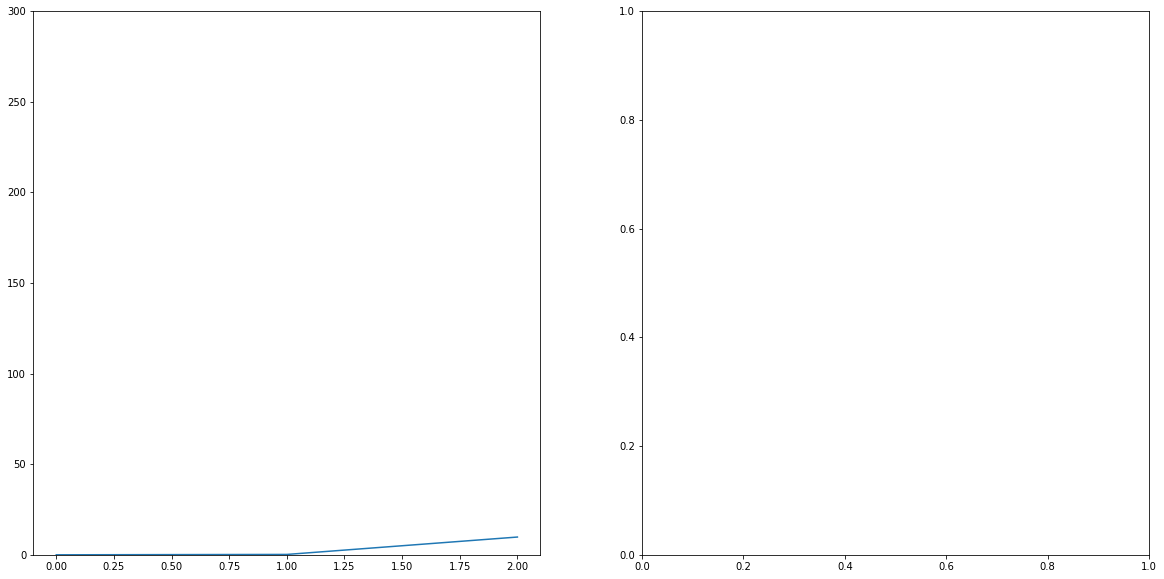

In [6]:
offset = 0
plt.clf()

fig , ax = plt.subplots(1, len(params), figsize=(20,10))
#concatenated_score = []
#concatenated_index = []
for task_id, score in enumerate(scores):
    #concatenated_score += score
    #concatenated_index += list(np.array([i for i in range(len(score))]) + offset)
    episode = np.array([i for i in range(len(score))])
    offseted_episode = list(episode + offset)
    ax[task_id].plot(episode, score)
    offset += len(score)
    ax[task_id].set_ylim([0,300])
    ax[task_id].set_title("Task n°{} (Length: {})".format(task_id, params[task_id]))
ax[0].set_ylabel("Score")


In [7]:
df3 = pd.read_csv(path)
print(df3)

      Unnamed: 0  Seed  Gravity  Length  Episode  Score
0              0     0      0.2     9.8        0   14.0
1              1     0      0.2     9.8        1   16.0
2              2     0      0.2     9.8        2   28.0
3              3     0      0.2     9.8        3   18.0
4              4     0      0.2     9.8        4   10.0
5              5     0      0.2     9.8        5   18.0
6              6     0      0.2     9.8        6   73.0
7              7     0      0.2     9.8        7   70.0
8              8     0      0.2     9.8        8   26.0
9              9     0      0.2     9.8        9   27.0
10            10     0      0.2     9.8       10   23.0
11            11     0      0.2     9.8       11   51.0
12            12     0      0.2     9.8       12   51.0
13            13     0      0.2     9.8       13   37.0
14            14     0      0.2     9.8       14   12.0
15            15     0      0.2     9.8       15   18.0
16            16     0      0.2     9.8       16